In [1]:
# 라이브러리 설정
import numpy as np
import cupy
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import gc
import glob
from tensorflow.keras.layers import Reshape
from keras.models import load_model
import keras

# 랜덤 시드 고정
SEED=2021
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
load_y=np.load('../Upscaling/Dataset_output/NON-WEAR_dataset.npz')  #이미지 데이터가 저장된 NPZ 로드하기.
Y_1 =load_y['arr_0']
load_y.close()
np.random.shuffle(Y_1)

  
Y_test = Y_1[-100:] 
Y_1 = Y_1[:-100]

del load_y
print(Y_1.shape)
gc.collect()

(22300, 800, 800, 3)


28

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3","/gpu:4","/gpu:5","/gpu:6","/gpu:7"])

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [3]:
# 오토인코더 모델 정의
def Autoencoder():
  with strategy.scope():
      X = tf.keras.layers.Input(shape=[800,800,3])

  #Encoder (Convolution layer 4겹)
      H = tf.keras.layers.Conv2D(3, (4, 4), (2, 2), activation='relu', padding='same')(X)
      H = tf.keras.layers.Conv2D(3 * 2, (4, 4), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.Conv2D(3 * 4, (4, 4), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.BatchNormalization()(H)
      H = tf.keras.layers.Conv2D(3 * 8, (4, 4), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.BatchNormalization()(H)
      H = tf.keras.layers.Conv2D(3 * 16, (4, 4), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.BatchNormalization()(H)
      H = tf.keras.layers.ZeroPadding2D(((1,0), (0,1)))(H)
      H = tf.keras.layers.Conv2D(3 * 32, (4, 4), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.BatchNormalization()(H)
    
      pool_temp = H.shape.as_list()
      pool_temp = pool_temp[1:]
    
    #Fully connected
      H = tf.keras.layers.Flatten()(H)
      flatten_temp = H.shape.as_list()
      flatten_temp = flatten_temp[1]
    
      H = tf.keras.layers.Dense(8000, activation='relu')(H)
      H = tf.keras.layers.Dense(flatten_temp, activation='relu')(H)
      H = Reshape(pool_temp)(H)
    
    #Decoder
      H = tf.keras.layers.Conv2DTranspose(3 * 32, (4,4),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.BatchNormalization()(H)
      H = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 1)))(H)
      H = tf.keras.layers.Conv2DTranspose(3 * 16, (4,4),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.BatchNormalization()(H)
      H = tf.keras.layers.Conv2DTranspose(3 * 8, (4,4),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.BatchNormalization()(H)
      H = tf.keras.layers.Conv2DTranspose(3 * 4, (4,4),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.Conv2DTranspose(3 * 2, (4,4),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.Conv2DTranspose(3, (4,4),strides=(2,2),padding='same',activation='relu')(H)
    
      model = tf.keras.models.Model(X,H)
      model.compile(optimizer='adam',loss='mean_squared_logarithmic_error', metrics=['acc']) #MSLE Loss Funciton 적용
      return model

ae_model = Autoencoder()
ae_model.summary()
#tf.compat.v1.disable_eager_execution()



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [5]:
#모델 체크포인트 설정
checkpoint_path = './check/checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only = True,
                                                save_best_only = True,
                                                monitor='val_acc',
                                                verbose=1)

In [10]:

history = ae_model.fit(Y_1,
                       Y_1,
                       batch_size=128, #한번에 학습할 데이터 Batch_size
                       epochs=20,      #에포크 설정
                       verbose=1,      #학습과정 시각화     
                       callbacks=[checkpoint],  #모델 체크포인트 저장
                       validation_split=0.2)         

from keras.models import load_model
ae_model.save('./check/model.h5')

Epoch 1/20
140/140 [==============================] - 180s 1s/step - loss: 9.1631e-04 - acc: 0.7680 - val_loss: 0.0010 - val_acc: 0.7207

Epoch 00001: val_acc did not improve from 0.76721
Epoch 2/20
140/140 [==============================] - 132s 943ms/step - loss: 9.2922e-04 - acc: 0.7690 - val_loss: 9.3803e-04 - val_acc: 0.7768

Epoch 00002: val_acc improved from 0.76721 to 0.77680, saving model to ./check/checkpoint.ckpt
Epoch 3/20
140/140 [==============================] - 110s 783ms/step - loss: 9.1545e-04 - acc: 0.7727 - val_loss: 0.0013 - val_acc: 0.7603

Epoch 00003: val_acc did not improve from 0.77680
Epoch 4/20
140/140 [==============================] - 97s 690ms/step - loss: 9.3082e-04 - acc: 0.7721 - val_loss: 9.2675e-04 - val_acc: 0.7780

Epoch 00004: val_acc improved from 0.77680 to 0.77801, saving model to ./check/checkpoint.ckpt
Epoch 5/20
140/140 [==============================] - 85s 608ms/step - loss: 8.7232e-04 - acc: 0.7780 - val_loss: 9.3819e-04 - val_acc: 0.7849

In [5]:
from keras.models import load_model
ae_model = load_model('./check/model.h5')

In [11]:
ae_images = ae_model.predict(Y_test)  #Pre-trained Model 평가용
ae_images.shape

(100, 800, 800, 3)

In [45]:
print(Y_test.shape)
print(ae_images.shape)

(100, 800, 800, 3)
(100, 800, 800, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


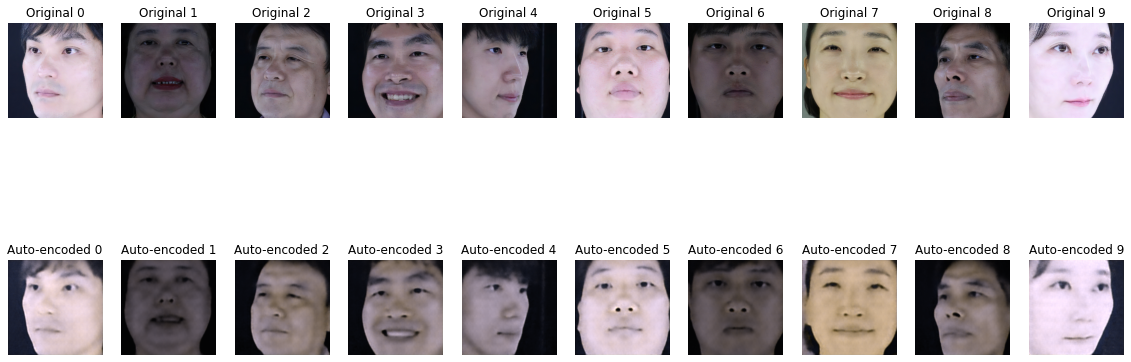

In [44]:
#이미지 출력
num = 10 
plt.figure(figsize=(20,8))
for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(Y_test[i*10 + 5])
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(ae_images[i*10 + 5])
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
    
plt.show()

# 전이학습 이전 Predict

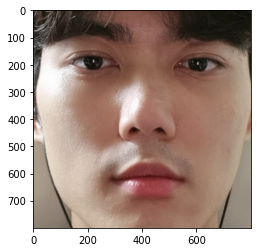

(800, 800, 3)


In [12]:
testpath = 'testCaptain.jpg'

img = cv2.imread(testpath)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

print(img.shape)

In [13]:
img = img.reshape(1, 800, 800, 3)
print(img.shape)

(1, 800, 800, 3)


In [38]:
predict_before_learning = ae_model.predict(img)

In [39]:
predict_before_learning.shape

(1, 800, 800, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


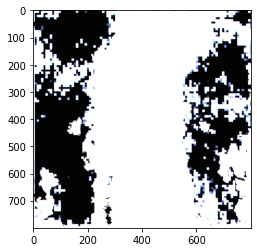

In [41]:
plt.imshow(predict_before_learning[0])
plt.show()

# 전이학습

In [3]:
#기존 모델 불러오기
from keras.models import load_model #이거 없으니까 OOM 뜸

with strategy.scope():
    ae_model = load_model('./check/model.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [4]:
import glob

#팀장 데이터 불러오기 (Pre-Trained Model에 추가학습용) -> 동영상 프레임 추출 사진
minsu = glob.glob('./TransferLearningImages/videoimage3/*.png')
test_minsu = []
for _ in range(0,len(minsu)):
  img = cv2.imread(minsu[_])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  test_minsu.append(img.astype("float32")/255.0)
  
test_minsu = np.array(test_minsu)
np.random.shuffle(test_minsu)

print(test_minsu.shape)

(1912, 800, 800, 3)


In [5]:
val_minsu = test_minsu[-100:]
test_minsu = test_minsu[:-100]

print(val_minsu.shape)
print(test_minsu.shape)

(100, 800, 800, 3)
(1812, 800, 800, 3)


In [5]:
ae_model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='mean_squared_logarithmic_error', metrics=['acc']) 
ae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 800, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 400, 400, 3)       147       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 6)       294       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 12)      1164      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 12)      48        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 24)        4632      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 24)        96    

In [6]:
#모델 체크포인트 설정
checkpoint_path = 'checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only = True,
                                                save_best_only = True,
                                                monitor='val_acc',
                                                verbose=1)

In [8]:
history = ae_model.fit(test_minsu,
                       test_minsu,
                       batch_size=8, #한번에 학습할 데이터 Batch_size
                       epochs=30,      #에포크 설정
                       verbose=1,      #학습과정 시각화                     
                       callbacks=[checkpoint],  #모델 체크포인트 저장
                       validation_split=0.2)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
182/182 [==============================] - 112s 447ms/step - loss: 0.0025 - acc: 0.7478 - val_loss: 0.0011 - val_acc: 0.8525

Epoch 00001: val_acc improved from -inf to 0.85247, saving model to checkpoint.ckpt
Epoch 2/30
182/182 [==============================] - 74s 407ms/step - loss: 9.2065e-04 - acc: 0.8547 - val_loss: 9.3116e-04 - val_acc: 0.8595

Epoch 00002: val_acc improved from 0.85247 to 0.85951, saving model to checkpoint.ckpt


KeyboardInterrupt: 

In [9]:
trans_imgs = ae_model.predict(val_minsu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

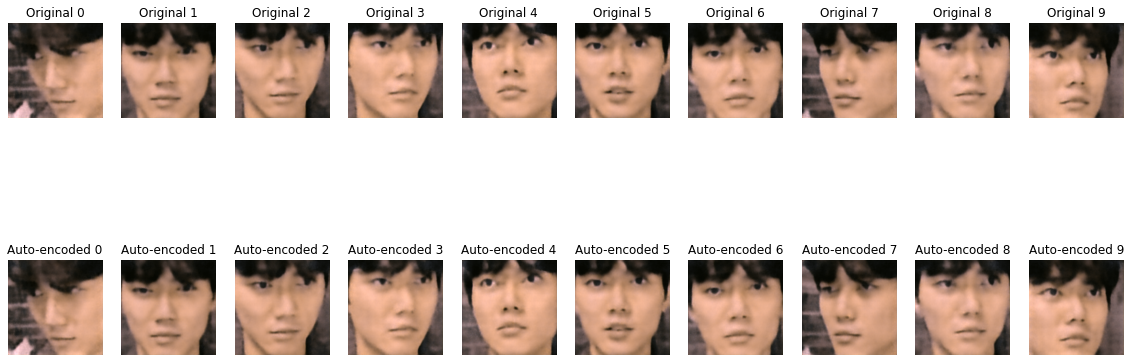

In [11]:
#이미지 출력
num = 10
plt.figure(figsize=(20,8))
for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(trans_imgs[i*10])
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(trans_imgs[i*10])
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
    
plt.show()

여기서 보니 original(위에사진들)이 잘못 들어감...

그래도 출력이 괜찮게 나온 것으로 판단

In [14]:
trans_img = ae_model.predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


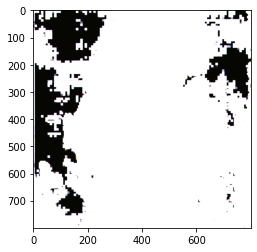

In [16]:
plt.imshow(trans_img[0])
plt.show()

# Test Data에 img를 추가하고 전이학습

In [35]:
#기존 모델 불러오기
from keras.models import load_model #이거 없으니까 OOM 뜸

with strategy.scope():
    ae_model = load_model('./check/model.h5')

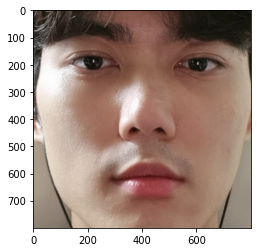

(800, 800, 3)


In [36]:
testpath = 'testCaptain.jpg'

img_target = cv2.imread(testpath)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))
plt.show()

print(img_target.shape)

In [40]:
import glob

#팀장 데이터 불러오기 (Pre-Trained Model에 추가학습용) -> 동영상 프레임 추출 사진
minsu = glob.glob('./TransferLearningImages/videoimage3/*.png')
test_minsu = []
for _ in range(0,len(minsu)):
  img = cv2.imread(minsu[_])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  test_minsu.append(img.astype("float32")/255.0)

img_target = cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB)
img_target = img_target.astype("float32")/255.0
#무지성 5회 추가
test_minsu.append(img_target)
test_minsu.append(img_target)
test_minsu.append(img_target)
test_minsu.append(img_target)
test_minsu.append(img_target)

test_minsu = np.array(test_minsu)
#np.random.shuffle(test_minsu)

print(test_minsu.shape)

(1917, 800, 800, 3)


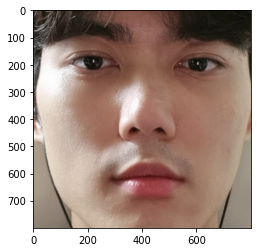

In [43]:
plt.imshow(test_minsu[1913])
plt.show()

In [44]:
np.random.shuffle(test_minsu)

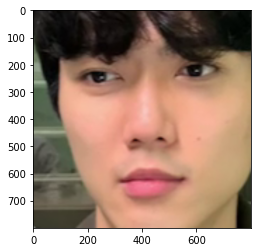

In [45]:
plt.imshow(test_minsu[1913])
plt.show()

In [46]:
val_minsu = test_minsu[-100:]
test_minsu = test_minsu[:-100]

print(val_minsu.shape)
print(test_minsu.shape)

(100, 800, 800, 3)
(1817, 800, 800, 3)


In [47]:
#LR 재설정
ae_model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='mean_squared_logarithmic_error', metrics=['acc']) 
ae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 800, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 400, 400, 3)       147       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 6)       294       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 12)      1164      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 12)      48        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 24)        4632      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 24)        96    

In [48]:
#모델 체크포인트 설정
checkpoint_path = 'checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only = True,
                                                save_best_only = True,
                                                monitor='val_acc',
                                                verbose=1)

In [49]:
history = ae_model.fit(test_minsu,
                       test_minsu,
                       batch_size=8, #한번에 학습할 데이터 Batch_size
                       epochs=2,      #에포크 설정
                       verbose=1,      #학습과정 시각화                     
                       callbacks=[checkpoint],  #모델 체크포인트 저장
                       validation_split=0.2)

Epoch 1/2
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
182/182 [==============================] - 99s 434ms/step - loss: 0.0026 - acc: 0.7415 - val_loss: 0.0011 - val_acc: 0.8512

Epoch 00001: val_acc improved from -inf to 0.85117, saving model to checkpoint.ckpt
Epoch 2/2
182/182 [==============================] - 76s 417ms/step - loss: 9.3810e-04 - acc: 0.8515 - val_loss: 9.4778e-04 - val_acc: 0.8625

Epoch 00002: val_acc improved from 0.85117 to 0.86253, saving model to checkpoint.ckpt


In [50]:
trans_imgs = ae_model.predict(val_minsu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


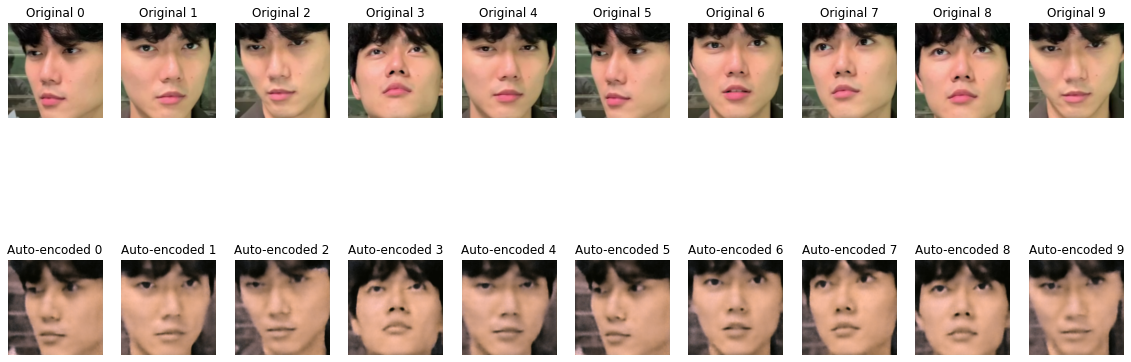

In [51]:
#이미지 출력
num = 10
plt.figure(figsize=(20,8))
for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(val_minsu[i*10])
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(trans_imgs[i*10])
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
    
plt.show()

In [52]:
trans_imgs = ae_model.predict(img_target.reshape(1, 800, 800, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


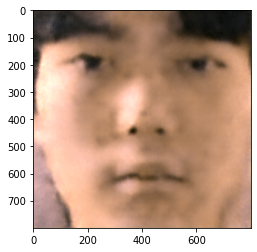

In [57]:
plt.imshow(trans_imgs[0])
plt.show()